# Adidas US Sales Analysis Notebook

This notebook analyzes Adidas US Sales data. It dynamically loads the latest dataset from the `datasets` folder, cleans the data, and provides key metrics and visualizations.

## 1. Data Loading

Import required libraries and load the most recent data file from the `datasets` directory.

In [61]:
from pathlib import Path
import pandas as pd

def get_latest_data(directory):
    """
    Get the most recently modified Excel/CSV file from the specified directory.
    Tries .xlsx, .xls, and .csv extensions automatically.
    
    Args:
        directory (str or Path): Directory to search for files
        
    Returns:
        pandas.DataFrame: Data from the most recent file
    """
    cleaned_dir = Path(directory)
    patterns = ['*.xlsx', '*.xls', '*.csv']
    files = []
    for pattern in patterns:
        files.extend(cleaned_dir.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No Excel or CSV files found in {cleaned_dir}")
    
    # Get the most recent file
    latest_file = max(files, key=lambda f: f.stat().st_mtime)
    
    # Read the file based on its extension
    if latest_file.suffix.lower() == '.csv':
        return pd.read_csv(latest_file)
    else:
        return pd.read_excel(latest_file)

In [62]:
# Load the latest Adidas US Sales data from the datasets folder
try:
    df = get_latest_data('datasets')
    print(df.head())
    print(df.columns)
except Exception as e:
    print(f"Error loading data: {e}")

Error loading data: No Excel or CSV files found in datasets


In [63]:
df.rename(columns={'OldName1': 'Total Sales', 'OldName2': 'Units Sold'}, inplace=True)

## 2. Data Cleaning

Clean and format the dataset (dates, missing values, etc.).

In [64]:
# Drop rows with missing values
df_clean = df.dropna()
print(f"Rows after dropping NA: {len(df_clean)}")

Rows after dropping NA: 0


In [65]:
# Convert date columns to datetime if present
for col in ['Order Date', 'Ship Date', 'Invoice Date']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

In [66]:
# Remove duplicate rows
df_clean = df_clean.drop_duplicates()
print(f"Rows after removing duplicates: {len(df_clean)}")

Rows after removing duplicates: 0


In [67]:
# Save cleaned data to cleaned/ folder
import os
os.makedirs('cleaned', exist_ok=True)
df_clean.to_excel('cleaned/cleaned_adidas_us_sales.xlsx', index=False)
print("✅ Cleaned file saved at: cleaned/cleaned_adidas_us_sales.xlsx")

✅ Cleaned file saved at: cleaned/cleaned_adidas_us_sales.xlsx


## 3. Analysis / Visualization

Perform analysis and visualize the processed data.

Columns used for cleaning: []
Before cleaning: (0, 7)
Empty DataFrame
Columns: [Operating Margin, Total Sales, Units Sold, Product, Region, Invoice Date, Price per Unit]
Index: []
After cleaning: (0, 7)
Empty DataFrame
Columns: [Operating Margin, Total Sales, Units Sold, Product, Region, Invoice Date, Price per Unit]
Index: []
Filled missing values in 'Operating Margin' with median: nan
Filled missing values in 'Total Sales' with median: nan
Filled missing values in 'Units Sold' with median: nan
Filled missing values in 'Price per Unit' with median: nan


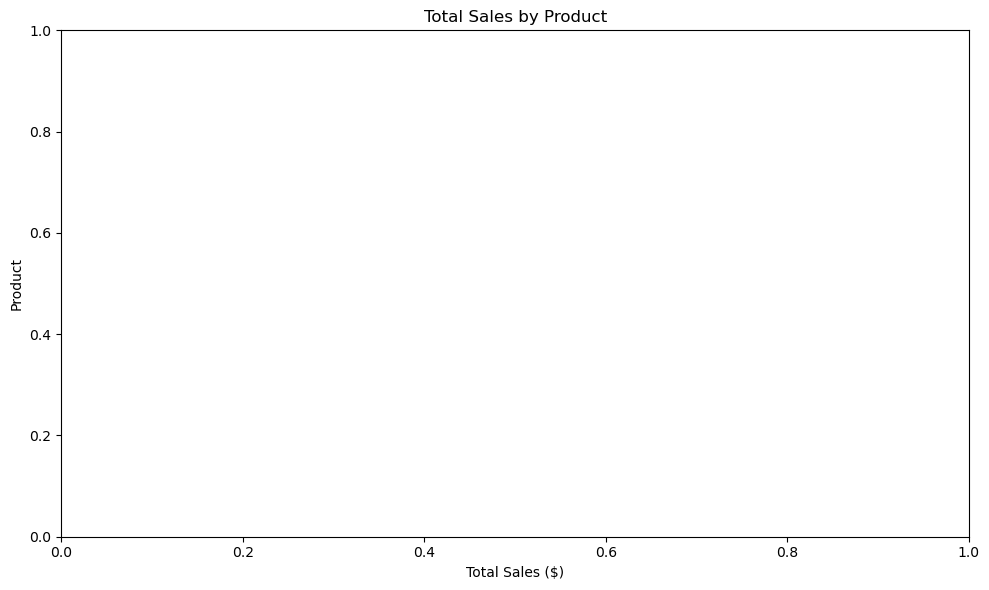

Monthly units sold:
Series([], Name: Units Sold, dtype: object)
No numeric monthly units sold data to plot.


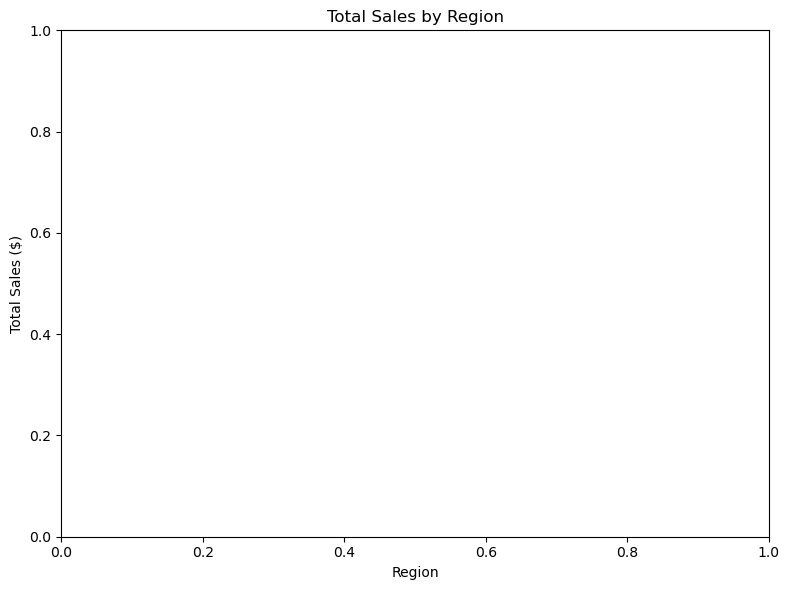

/var/folders/8j/x9lyph2d3gs2jpd9j543yqb80000gn/T/ipykernel_20098/3968109741.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


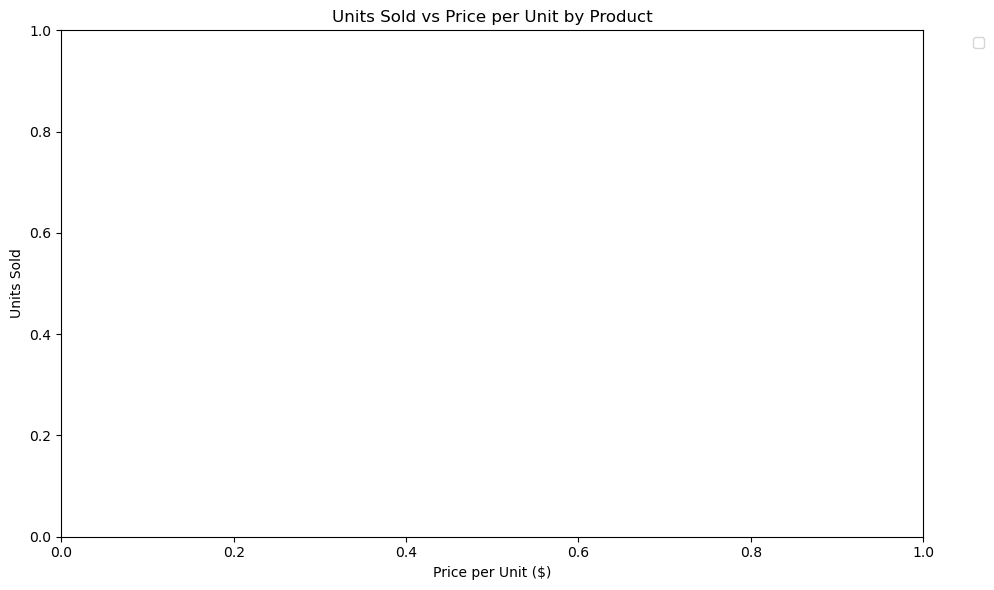

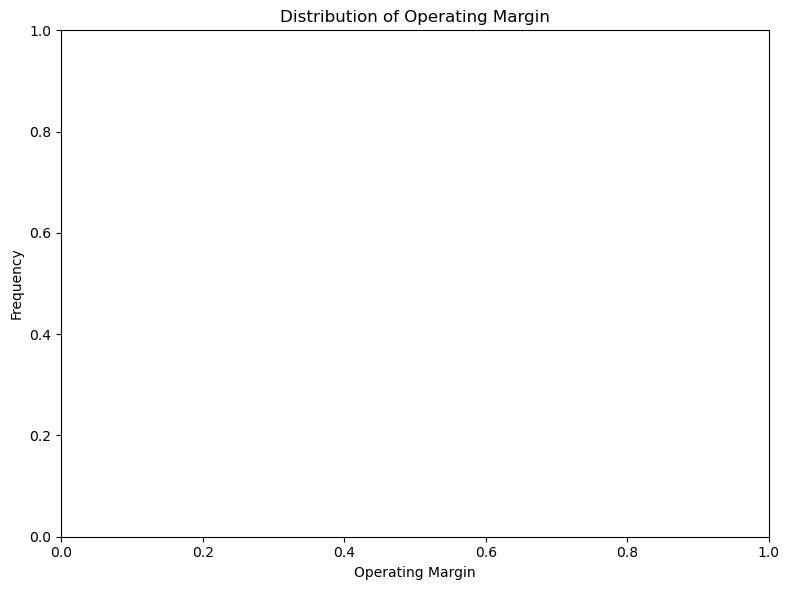

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Cleaning: Drop rows only for columns that exist and have non-missing values ---
key_columns = ['Operating Margin', 'Total Sales', 'Units Sold', 'Product', 'Region', 'Invoice Date', 'Price per Unit']
existing_nonempty_cols = [col for col in key_columns if col in df.columns and df[col].notna().any()]
print("Columns used for cleaning:", existing_nonempty_cols)
print("Before cleaning:", df.shape)
print(df.head())
df_clean = df.dropna(subset=existing_nonempty_cols)
print("After cleaning:", df_clean.shape)
print(df_clean.head())

# --- Fill missing numeric data in key columns using median ---
numeric_cols = ['Operating Margin', 'Total Sales', 'Units Sold', 'Price per Unit']
for col in numeric_cols:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)
        print(f"Filled missing values in '{col}' with median: {median_val}")

# --- 1. Total Sales by Product (Bar chart) ---
if 'Product' in df_clean.columns and 'Total Sales' in df_clean.columns:
    plt.figure(figsize=(10,6))
    sales_by_product = df_clean.groupby('Product')['Total Sales'].sum().sort_values(ascending=False)
    sns.barplot(x=sales_by_product.values, y=sales_by_product.index, palette='viridis')
    plt.title('Total Sales by Product')
    plt.xlabel('Total Sales ($)')
    plt.ylabel('Product')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'Product' or 'Total Sales' not found in df_clean.")

# --- 2. Monthly Units Sold Trend (Line chart) ---
if 'Invoice Date' in df_clean.columns and 'Units Sold' in df_clean.columns:
    df_clean['YearMonth'] = pd.to_datetime(df_clean['Invoice Date'], errors='coerce').dt.to_period('M')
    monthly_units_sold = df_clean.groupby('YearMonth')['Units Sold'].sum()
    monthly_units_sold.index = monthly_units_sold.index.to_timestamp()
    print("Monthly units sold:")
    print(monthly_units_sold)
    if not monthly_units_sold.empty and monthly_units_sold.apply(lambda x: isinstance(x, (int, float, complex)) and not pd.isna(x)).any():
        plt.figure(figsize=(12,6))
        monthly_units_sold.plot(marker='o')
        plt.title('Monthly Units Sold Over Time')
        plt.xlabel('Month')
        plt.ylabel('Units Sold')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric monthly units sold data to plot.")
else:
    print("Required columns 'Invoice Date' or 'Units Sold' not found in df_clean.")

# --- 3. Sales by Region (Bar chart) ---
if 'Region' in df_clean.columns and 'Total Sales' in df_clean.columns:
    plt.figure(figsize=(8,6))
    sales_by_region = df_clean.groupby('Region')['Total Sales'].sum().sort_values(ascending=False)
    sns.barplot(x=sales_by_region.index, y=sales_by_region.values, palette='coolwarm')
    plt.title('Total Sales by Region')
    plt.xlabel('Region')
    plt.ylabel('Total Sales ($)')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'Region' or 'Total Sales' not found in df_clean.")

# --- 4. Units Sold vs Price per Unit Scatter Plot (colored by Product) ---
if 'Price per Unit' in df_clean.columns and 'Units Sold' in df_clean.columns and 'Product' in df_clean.columns:
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df_clean, x='Price per Unit', y='Units Sold', hue='Product', alpha=0.7)
    plt.title('Units Sold vs Price per Unit by Product')
    plt.xlabel('Price per Unit ($)')
    plt.ylabel('Units Sold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns 'Price per Unit', 'Units Sold', or 'Product' not found in df_clean.")

# --- 5. Profit Margin Distribution (Histogram with KDE) ---
if 'Operating Margin' in df_clean.columns:
    plt.figure(figsize=(8,6))
    sns.histplot(df_clean['Operating Margin'], bins=30, kde=True, color='green')
    plt.title('Distribution of Operating Margin')
    plt.xlabel('Operating Margin')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'Operating Margin' not found in df_clean.")

## 4. Dashboard & Key Metrics

Calculate and display key metrics and a summary dashboard.

In [ ]:
# Summary Metrics
metrics = {}
if 'Total Sales' in df_clean.columns:
    metrics['total_sales'] = df_clean['Total Sales'].sum()
if 'Units Sold' in df_clean.columns:
    metrics['total_units'] = df_clean['Units Sold'].sum()
if 'Price per Unit' in df_clean.columns:
    metrics['avg_price'] = df_clean['Price per Unit'].mean()
if 'Product' in df_clean.columns and 'Total Sales' in df_clean.columns:
    product_sales = df_clean.groupby('Product')['Total Sales'].sum()
    if not product_sales.empty:
        metrics['top_product'] = product_sales.idxmax()
        metrics['top_product_sales'] = product_sales.max()
    else:
        print("No product sales data available for top product calculation.")
if 'Region' in df_clean.columns and 'Total Sales' in df_clean.columns:
    region_sales = df_clean.groupby('Region')['Total Sales'].sum()
    if not region_sales.empty:
        metrics['top_region'] = region_sales.idxmax()
        metrics['top_region_sales'] = region_sales.max()
    else:
        print("No region sales data available for top region calculation.")

print("📊 Adidas US Sales Dashboard")
if 'total_sales' in metrics:
    print(f"💰 Total Sales: ${metrics['total_sales']:,.2f}")
if 'total_units' in metrics:
    print(f"📦 Total Units Sold: {metrics['total_units']:,}")
if 'avg_price' in metrics:
    print(f"🏷 Avg Price/Unit: ${metrics['avg_price']:.2f}")
if 'top_product' in metrics:
    print(f"🏆 Top Product: {metrics['top_product']} (${metrics['top_product_sales']:,.2f})")
if 'top_region' in metrics:
    print(f"🌎 Top Region: {metrics['top_region']} (${metrics['top_region_sales']:,.2f})")

# --- Plot Key Metrics ---
import matplotlib.pyplot as plt

metric_names = []
metric_values = []
if 'total_sales' in metrics:
    metric_names.append('Total Sales')
    metric_values.append(metrics['total_sales'])
if 'total_units' in metrics:
    metric_names.append('Total Units Sold')
    metric_values.append(metrics['total_units'])
if 'avg_price' in metrics:
    metric_names.append('Avg Price/Unit')
    metric_values.append(metrics['avg_price'])
if 'top_product_sales' in metrics:
    metric_names.append(f"Top Product Sales ({metrics['top_product']})")
    metric_values.append(metrics['top_product_sales'])
if 'top_region_sales' in metrics:
    metric_names.append(f"Top Region Sales ({metrics['top_region']})")
    metric_values.append(metrics['top_region_sales'])

if metric_names and metric_values:
    plt.figure(figsize=(8,5))
    plt.barh(metric_names, metric_values, color=['#4caf50', '#2196f3', '#ff9800', '#9c27b0', '#e91e63'])
    plt.xlabel('Value')
    plt.title('Adidas US Sales Key Metrics')
    for i, v in enumerate(metric_values):
        plt.text(v, i, f'{v:,.2f}', va='center', ha='left', fontsize=10)
    plt.tight_layout()
    plt.show()
else:
    print("No key metrics available to plot.")

No product sales data available for top product calculation.
No region sales data available for top region calculation.
📊 Adidas US Sales Dashboard
💰 Total Sales: $0.00
📦 Total Units Sold: 0
🏷 Avg Price/Unit: $nan
